## Import libraries

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix
from sklearn.feature_selection import RFE, SelectFromModel
from sklearn.decomposition import PCA

## Loading data

##### CSV file loading

In [2]:
X_train = pd.read_csv('data/X_train_cleaned.csv')
X_test = pd.read_csv('data/X_test_cleaned.csv')
y_train = pd.read_csv('data/y_train_cleaned.csv')
y_test = pd.read_csv('data/y_test_cleaned.csv')
df_pred = pd.read_csv('data/df_pred_cleaned.csv')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Data engineering

##### 1.Handling NaN, None, Null.

In [3]:
age_imputer = SimpleImputer(strategy='median')
X_train['Age'] = age_imputer.fit_transform(X_train[['Age']])
X_test['Age'] = age_imputer.transform(X_test[['Age']])
df_pred['Age'] = age_imputer.transform(df_pred[['Age']])

X_train['HasCabin'] = X_train['Cabin'].notna().astype(int)
X_test['HasCabin'] = X_test['Cabin'].notna().astype(int)
df_pred['HasCabin'] = df_pred['Cabin'].notna().astype(int)

X_train.head(6)

,Id,Class,Name,Sex,Age,Siblings_Spouses,Parents_Childs,Ticket,Fare,Cabin,Embarked,HasCabin
0,693,3,"Lam, Mr. Ali",male,28.5,0,0,1601,56.4958,NaN,S,0
1,482,2,"Frost, Mr. Anthony Wood ""Archie""",male,28.5,0,0,239854,0.0000,NaN,S,0
2,528,1,"Farthing, Mr. John",male,28.5,0,0,PC 17483,221.7792,C95,S,1
3,856,3,"Aks, Mrs. Sam (Leah Rosen)",female,18.0,0,1,392091,9.3500,NaN,S,0
4,802,2,"Collyer, Mrs. Harvey (Charlotte Annie Tate)",female,31.0,1,1,C.A. 31921,26.2500,NaN,S,0
5,653,3,"Kalvik, Mr. Johannes Halvorsen",male,21.0,0,0,8475,8.4333,NaN,S,0


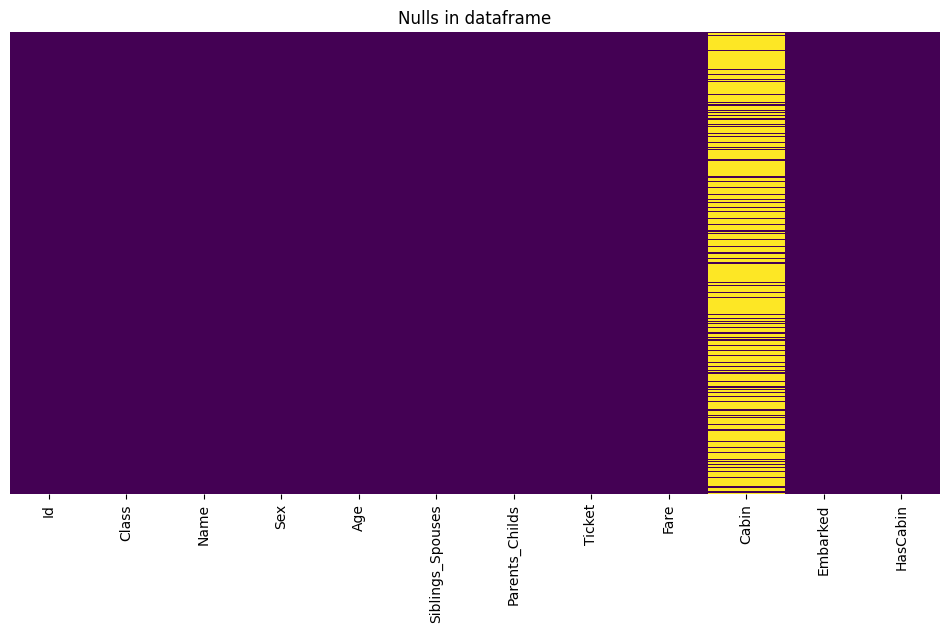

In [4]:
df_full = pd.concat([X_train, X_test, df_pred], axis=0, ignore_index=True)

plt.figure(figsize=(12, 6))
sns.heatmap(df_full.isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title('Nulls in dataframe')
plt.savefig('../images/isnull_fixed.png', dpi=300, bbox_inches='tight')
plt.show()

##### NOTE: *Column "Cabin" I will delete later.*

##### 2.Adding columns.

In [5]:
for df in [X_test, X_train, df_pred]:
    df['FamilySize'] = 1 + df['Siblings_Spouses'] + df['Parents_Childs']
    df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
X_train.head(5)

,Id,Class,Name,Sex,Age,Siblings_Spouses,Parents_Childs,Ticket,Fare,Cabin,Embarked,HasCabin,FamilySize,Title
0,693,3,"Lam, Mr. Ali",male,28.5,0,0,1601,56.4958,NaN,S,0,1,Mr
1,482,2,"Frost, Mr. Anthony Wood ""Archie""",male,28.5,0,0,239854,0.0000,NaN,S,0,1,Mr
2,528,1,"Farthing, Mr. John",male,28.5,0,0,PC 17483,221.7792,C95,S,1,1,Mr
3,856,3,"Aks, Mrs. Sam (Leah Rosen)",female,18.0,0,1,392091,9.3500,NaN,S,0,2,Mrs
4,802,2,"Collyer, Mrs. Harvey (Charlotte Annie Tate)",female,31.0,1,1,C.A. 31921,26.2500,NaN,S,0,3,Mrs


##### 3.Removing unnecessary columns.

In [6]:
df_full['Ticket'].value_counts().sort_values(ascending=False).head(10)

Ticket
CA. 2343        11
CA 2144          8
1601             8
347077           7
PC 17608         7
3101295          7
347082           7
S.O.C. 14879     7
382652           6
113781           6
Name: count, dtype: int64

In [7]:
for df in [X_test, X_train]:
    df.drop(columns=['Id', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)

for df in [df_pred]:
    df.drop(columns=['Name', 'Ticket', 'Cabin'], axis=1, inplace=True)
    
X_train.head(1)

,Class,Sex,Age,Siblings_Spouses,Parents_Childs,Fare,Embarked,HasCabin,FamilySize,Title
0,3,male,28.5,0,0,56.4958,S,0,1,Mr


##### SUMMARY: *I could extract from "Ticket" for example prefix, but I decided to delete it, due to many unique values.*

##### 4.Fixing columns data types. Encoding categorical variables.

In [8]:
X_train.dtypes

Class                 int64
Sex                  object
Age                 float64
Siblings_Spouses      int64
Parents_Childs        int64
Fare                float64
Embarked             object
HasCabin              int32
FamilySize            int64
Title                object
dtype: object

In [9]:
for df in [X_test, X_train, df_pred]:
    columns = ['Age', 'HasCabin']
    for col in columns:
        df[col] = df[col].astype('int64')

X_train.dtypes

Class                 int64
Sex                  object
Age                   int64
Siblings_Spouses      int64
Parents_Childs        int64
Fare                float64
Embarked             object
HasCabin              int64
FamilySize            int64
Title                object
dtype: object

In [10]:
X_train.head()

,Class,Sex,Age,Siblings_Spouses,Parents_Childs,Fare,Embarked,HasCabin,FamilySize,Title
0,3,male,28,0,0,56.4958,S,0,1,Mr
1,2,male,28,0,0,0.0000,S,0,1,Mr
2,1,male,28,0,0,221.7792,S,1,1,Mr
3,3,female,18,0,1,9.3500,S,0,2,Mrs
4,2,female,31,1,1,26.2500,S,0,3,Mrs


In [11]:
df_full['Embarked'].isnull().sum()

2

In [12]:
df_full['Embarked'].value_counts()

Embarked
S    914
C    270
Q    123
Name: count, dtype: int64

In [13]:
for df in [X_test, X_train, df_pred]:
    df['Embarked'] = df['Embarked'].fillna(value='S')

##### NOTE: *I have replaced missing two values in column "Embarked" with most popular "S".*

In [14]:
df_full['Fare'].isnull().sum()

1

In [15]:
for df in [X_test, X_train, df_pred]:
    df['Fare'] = df.groupby('Class')['Fare'].transform(lambda x: x.fillna(x.median()))

In [16]:
for df in [X_test, X_train, df_pred]:
    print(df['Title'].unique())

['Mr' 'Miss' 'Mrs' 'Major' 'Mme' 'Master' 'Capt' 'Countess' 'Dr' 'Rev']
['Mr' 'Mrs' 'Col' 'Miss' 'Rev' 'Major' 'Master' 'Dr' 'Mlle' 'Lady' 'Sir'
 'Ms' 'Jonkheer' 'Don']
['Mr' 'Mrs' 'Miss' 'Master' 'Ms' 'Col' 'Rev' 'Dr' 'Dona']


In [17]:
for df in [X_test, X_train, df_pred]:
    df['Title'] = df['Title'].replace(['Master', 'Don', 'Rev', 'Dr', 'Major', 'Col', 'Sir', 'Capt', 'Countess', 'Jonkheer', 'Dona'], 'Rare')
    df['Title'] = df['Title'].replace('Mlle', 'Miss')
    df['Title'] = df['Title'].replace('Lady', 'Ms')
    df['Title'] = df['Title'].replace('Mme', 'Mrs')

for df in [X_test, X_train, df_pred]:
    print(df['Title'].unique())

['Mr' 'Miss' 'Mrs' 'Rare']
['Mr' 'Mrs' 'Rare' 'Miss' 'Ms']
['Mr' 'Mrs' 'Miss' 'Rare' 'Ms']


In [18]:
columns = ['Title', 'Sex', 'Embarked']
encoders = {}
for column in columns:
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore', dtype=int)
    encoded = encoder.fit_transform(X_train[[column]])
    encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out([column]), index=X_train.index)
    X_train = pd.concat([X_train.drop(column, axis=1), encoded_df], axis=1)
    encoders[column] = encoder
    
for dataset in [X_test, df_pred]:
    for column in columns:
        encoder = encoders[column]
        encoded = encoder.transform(dataset[[column]])
        encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out([column]), index=dataset.index)
        dataset.drop(column, axis=1, inplace=True)
        dataset[encoded_df.columns] = encoded_df

In [19]:
X_train.head()

,Class,Age,Siblings_Spouses,Parents_Childs,Fare,HasCabin,FamilySize,Title_Miss,Title_Mr,Title_Mrs,Title_Ms,Title_Rare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,3,28,0,0,56.4958,0,1,0,1,0,0,0,0,1,0,0,1
1,2,28,0,0,0.0000,0,1,0,1,0,0,0,0,1,0,0,1
2,1,28,0,0,221.7792,1,1,0,1,0,0,0,0,1,0,0,1
3,3,18,0,1,9.3500,0,2,0,0,1,0,0,1,0,0,0,1
4,2,31,1,1,26.2500,0,3,0,0,1,0,0,1,0,0,0,1


In [20]:
X_train['Fare_Bins'], bins = pd.qcut(X_train['Fare'], q=3, labels=[0, 1, 2], retbins=True)
X_train.drop(columns=['Fare'], inplace=True)

for df in [X_test, df_pred]:
    df['Fare_Bins'] = pd.cut(df['Fare'], bins=bins, labels=[0, 1, 2], include_lowest=True)
    df.drop(columns=['Fare'], inplace=True)

In [21]:
for df in [X_train, X_test, df_pred]:
    print(df['Fare_Bins'].value_counts())

Fare_Bins
1    242
0    237
2    233
Name: count, dtype: int64
Fare_Bins
2    62
1    60
0    57
Name: count, dtype: int64
Fare_Bins
1    148
0    139
2    131
Name: count, dtype: int64


In [22]:
X_train['Fare_Bins'] = X_train['Fare_Bins'].astype(int)
for df in [X_test, df_pred]:
    df['Fare_Bins'] = df['Fare_Bins'].astype(int)

In [23]:
X_train.head()

,Class,Age,Siblings_Spouses,Parents_Childs,HasCabin,FamilySize,Title_Miss,Title_Mr,Title_Mrs,Title_Ms,Title_Rare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Fare_Bins
0,3,28,0,0,0,1,0,1,0,0,0,0,1,0,0,1,2
1,2,28,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0
2,1,28,0,0,1,1,0,1,0,0,0,0,1,0,0,1,2
3,3,18,0,1,0,2,0,0,1,0,0,1,0,0,0,1,1
4,2,31,1,1,0,3,0,0,1,0,0,1,0,0,0,1,2


In [24]:
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore', dtype=int)
encoded = encoder.fit_transform(X_train[['Fare_Bins']])
encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(['Fare_Bins']), index=X_train.index)
X_train = pd.concat([X_train.drop('Fare_Bins', axis=1), encoded_df], axis=1)
    
for dataset in [X_test, df_pred]:
    encoded = encoder.transform(dataset[['Fare_Bins']])
    encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(['Fare_Bins']), index=dataset.index)
    dataset.drop('Fare_Bins', axis=1, inplace=True)
    dataset[encoded_df.columns] = encoded_df

X_train.head(1)

,Class,Age,Siblings_Spouses,Parents_Childs,HasCabin,FamilySize,Title_Miss,Title_Mr,Title_Mrs,Title_Ms,Title_Rare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Fare_Bins_0,Fare_Bins_1,Fare_Bins_2
0,3,28,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,1


## Creating and training basic models. Metrics

Models Creation

In [25]:
models = {
    'Logistic Regression': make_pipeline(StandardScaler(), LogisticRegression(random_state=42, max_iter=1000)),
    'Random Forest': RandomForestClassifier(random_state=42),
    'KNN': make_pipeline(StandardScaler(), KNeighborsClassifier()),
    'XGB': XGBClassifier(random_state=42),
    'SVC': make_pipeline(StandardScaler(), SVC(probability=True, random_state=42))
}

##### Models Training and Metrics

In [26]:
y_test.value_counts(normalize=True)


Survived
0           0.614525
1           0.385475
Name: proportion, dtype: float64

In [27]:
def evaluate_model(model, X_test, y_test, name):
    y_pred = model.predict(X_test)
    print(f'\n{name}:')
    print('Accuracy:  {:0.2f}'.format(accuracy_score(y_test, y_pred)))
    print('Precision: {:0.2f}'.format(precision_score(y_test, y_pred)))
    print('Recall:   {:0.2f}'.format(recall_score(y_test, y_pred)))
    print('Roc Auc: {:0.2f}'.format(roc_auc_score(y_test, y_pred)))
    print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))
    
for name, model in models.items():
    model.fit(X_train, y_train)
    joblib.dump(model, f"data\{name.lower().replace(' ', '_')}.pkl")
    evaluate_model(model, X_test, y_test, name)


Logistic Regression:
Accuracy:  0.82
Precision: 0.78
Recall:   0.72
Roc Auc: 0.80
Confusion Matrix:
 [[96 14]
 [19 50]]


e:\Python moje\projekty\3.ML_classification_comparison_titanic\.venv\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Krzychu\AppData\Local\Temp\ipykernel_1204\3497455588.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)



Random Forest:
Accuracy:  0.80
Precision: 0.74
Recall:   0.74
Roc Auc: 0.79
Confusion Matrix:
 [[92 18]
 [18 51]]

KNN:
Accuracy:  0.81
Precision: 0.77
Recall:   0.72
Roc Auc: 0.79
Confusion Matrix:
 [[95 15]
 [19 50]]


e:\Python moje\projekty\3.ML_classification_comparison_titanic\.venv\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)



XGB:
Accuracy:  0.81
Precision: 0.78
Recall:   0.71
Roc Auc: 0.79
Confusion Matrix:
 [[96 14]
 [20 49]]

SVC:
Accuracy:  0.82
Precision: 0.79
Recall:   0.72
Roc Auc: 0.80
Confusion Matrix:
 [[97 13]
 [19 50]]


e:\Python moje\projekty\3.ML_classification_comparison_titanic\.venv\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## Feature Selection/Extraction and New Models

##### Models Creation

In [28]:
n_features_to_select = 8
lr_rfe = RFE(estimator=LogisticRegression(), n_features_to_select=n_features_to_select)
rf_sfm = SelectFromModel(estimator=RandomForestClassifier(random_state=42), max_features=n_features_to_select)
knn_pca = PCA(n_components=n_features_to_select)
xgb_sfm = SelectFromModel(estimator=XGBClassifier(random_state=42), max_features=n_features_to_select)
svc_pca = PCA(n_components=n_features_to_select)

models_fs = {
    'Logistic Regression RFE': make_pipeline(StandardScaler(), lr_rfe, LogisticRegression(random_state=42, max_iter=1000)),
    'Random Forest SFM': make_pipeline(rf_sfm, RandomForestClassifier(random_state=42)),
    'KNN PCA': make_pipeline(StandardScaler(), knn_pca, KNeighborsClassifier()),
    'XGB SFM': make_pipeline(xgb_sfm, XGBClassifier(random_state=42)),
    'SVC PCA': make_pipeline(StandardScaler(), svc_pca, SVC(probability=True, random_state=42))
}

##### Models Training and Metrics

In [29]:
results = []

for name, model in models_fs.items():
    cv_results = cross_validate(
        model,
        X_train,
        y_train,
        cv=5,
        scoring=['accuracy', 'precision', 'recall', 'roc_auc'],
        return_train_score=False,
        return_estimator=True
    )
    
    for i in range(5):
        results.append({
            'Model': name,
            'Fold': i + 1,
            'Accuracy': cv_results['test_accuracy'][i],
            'Precision': cv_results['test_precision'][i],
            'Recall': cv_results['test_recall'][i],
            'ROC AUC': cv_results['test_roc_auc'][i]
        })
    recalls = cv_results['test_recall']
    estimators = cv_results['estimator']
    
    best_idx = np.argmax(recalls)
    best_recall = recalls[best_idx]
    best_model = estimators[best_idx]
    
    print(f'Best recall metric for {name}: {best_recall:.3f} at fold {best_idx+1}')
    joblib.dump(best_model, f"data\{name.lower().replace(' ', '_')}.pkl")
    
cv_df = pd.DataFrame(results)
cv_df

e:\Python moje\projekty\3.ML_classification_comparison_titanic\.venv\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
e:\Python moje\projekty\3.ML_classification_comparison_titanic\.venv\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
e:\Python moje\projekty\3.ML_classification_comparison_titanic\.venv\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
e:\Python moje\projekty\3.ML_classification_comparison_titanic\.venv\l

Best recall metric for Logistic Regression RFE: 0.800 at fold 1


e:\Python moje\projekty\3.ML_classification_comparison_titanic\.venv\lib\site-packages\sklearn\pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
e:\Python moje\projekty\3.ML_classification_comparison_titanic\.venv\lib\site-packages\sklearn\feature_selection\_from_model.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
e:\Python moje\projekty\3.ML_classification_comparison_titanic\.venv\lib\site-packages\sklearn\pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
e:\Python moje\pro

Best recall metric for Random Forest SFM: 0.778 at fold 4


e:\Python moje\projekty\3.ML_classification_comparison_titanic\.venv\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
e:\Python moje\projekty\3.ML_classification_comparison_titanic\.venv\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
e:\Python moje\projekty\3.ML_classification_comparison_titanic\.venv\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
e:\Python moje\projekty\3.ML_classification_comparison_titanic\.venv\lib\

Best recall metric for KNN PCA: 0.818 at fold 3
Best recall metric for XGB SFM: 0.745 at fold 1


e:\Python moje\projekty\3.ML_classification_comparison_titanic\.venv\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
e:\Python moje\projekty\3.ML_classification_comparison_titanic\.venv\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
e:\Python moje\projekty\3.ML_classification_comparison_titanic\.venv\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best recall metric for SVC PCA: 0.782 at fold 3


e:\Python moje\projekty\3.ML_classification_comparison_titanic\.venv\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
e:\Python moje\projekty\3.ML_classification_comparison_titanic\.venv\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,Model,Fold,Accuracy,Precision,Recall,ROC AUC
0,Logistic Regression RFE,1,0.825175,0.758621,0.800000,0.847831
1,Logistic Regression RFE,2,0.762238,0.723404,0.618182,0.859298
2,Logistic Regression RFE,3,0.845070,0.811321,0.781818,0.873877
3,Logistic Regression RFE,4,0.830986,0.777778,0.777778,0.878683
4,Logistic Regression RFE,5,0.816901,0.759259,0.759259,0.870370
5,Random Forest SFM,1,0.769231,0.720000,0.654545,0.813326
6,Random Forest SFM,2,0.769231,0.750000,0.600000,0.835331
7,Random Forest SFM,3,0.809859,0.769231,0.727273,0.867398
8,Random Forest SFM,4,0.845070,0.807692,0.777778,0.891730
9,Random Forest SFM,5,0.802817,0.740741,0.740741,0.821444


##### SUMMAR: *Considering human life I decided recall metric is most important and models with highest value I have choosen to save.*

## Hyperparameter Tuning and New Models

##### Models and Parameters Creation

In [30]:
pipe_lr = make_pipeline(StandardScaler(), RFE(estimator=LogisticRegression()), LogisticRegression(random_state=42, max_iter=1000))
pipe_rf = make_pipeline(SelectFromModel(estimator=RandomForestClassifier(random_state=42)), RandomForestClassifier(random_state=42))
pipe_knn = make_pipeline(StandardScaler(), PCA(), KNeighborsClassifier())
pipe_xgb = make_pipeline(SelectFromModel(estimator=XGBClassifier(random_state=42)), XGBClassifier(random_state=42))
pipe_svc = make_pipeline(StandardScaler(), PCA(), SVC(probability=True, random_state=42))

param_grid_lr = {
    'rfe__n_features_to_select': [6, 8, 11, 16, 19],
    'logisticregression__C': [0.1, 1.0, 10.0]
}

param_grid_rf = {
    'selectfrommodel__max_features': [6, 8, 11, 16, 19],
    'randomforestclassifier__n_estimators': [50, 100, 200],
    'randomforestclassifier__max_depth': [None, 5, 10, 20]
}

param_grid_knn = {
    'pca__n_components': [6, 8, 11, 16, 19],
    'kneighborsclassifier__n_neighbors': [3, 5, 7],
    'kneighborsclassifier__weights': ['uniform', 'distance']
}

param_grid_xgb = {
    'selectfrommodel__max_features': [6, 8, 11, 16, 19],
    'xgbclassifier__n_estimators': [50, 100],
    'xgbclassifier__max_depth': [3, 6],
    'xgbclassifier__learning_rate': [0.01, 0.1, 0.3]
}

param_grid_svc = {
    'pca__n_components': [6, 8, 11, 16, 19],
    'svc__C': [0.1, 1.0, 10.0],
    'svc__gamma': ['scale', 'auto'],
    'svc__kernel': ['rbf', 'linear']
}

models_params = {
    'Logistic Regression RFE CV': (pipe_lr, param_grid_lr),
    'Random Forest SFM CV': (pipe_rf, param_grid_rf),
    'KNN PCA CV': (pipe_knn, param_grid_knn),
    'XGBoost SFM CV': (pipe_xgb, param_grid_xgb),
    'SVC PCA CV': (pipe_svc, param_grid_svc)
}

##### Model Training and Metrics

In [31]:
def evaluate_model(model, X_test, y_test, name):
    y_pred = model.predict(X_test)
    print(f'\n{name}:')
    print('Accuracy:  {:0.2f}'.format(accuracy_score(y_test, y_pred)))
    print('Precision: {:0.2f}'.format(precision_score(y_test, y_pred)))
    print('Recall:   {:0.2f}'.format(recall_score(y_test, y_pred)))
    print('Roc Auc: {:0.2f}'.format(roc_auc_score(y_test, y_pred)))
    print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))
    
best_models = {}

for name, (pipeline, param_grid) in models_params.items():
    grid = GridSearchCV(pipeline, param_grid=param_grid, cv=5, n_jobs=-1, verbose=0, scoring='recall')
    grid.fit(X_train, y_train)

    print(f"\nBest params for {name}: {grid.best_params_}")
    best_model = grid.best_estimator_

    joblib.dump(best_model, f"data\{name.lower().replace(' ', '_')}.pkl")
    evaluate_model(best_model, X_test, y_test, name)
    best_models[name] = best_model

e:\Python moje\projekty\3.ML_classification_comparison_titanic\.venv\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
e:\Python moje\projekty\3.ML_classification_comparison_titanic\.venv\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Best params for Logistic Regression RFE CV: {'logisticregression__C': 1.0, 'rfe__n_features_to_select': 19}

Logistic Regression RFE CV:
Accuracy:  0.82
Precision: 0.78
Recall:   0.72
Roc Auc: 0.80
Confusion Matrix:
 [[96 14]
 [19 50]]


e:\Python moje\projekty\3.ML_classification_comparison_titanic\.venv\lib\site-packages\sklearn\feature_selection\_from_model.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
e:\Python moje\projekty\3.ML_classification_comparison_titanic\.venv\lib\site-packages\sklearn\pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)



Best params for Random Forest SFM CV: {'randomforestclassifier__max_depth': 5, 'randomforestclassifier__n_estimators': 50, 'selectfrommodel__max_features': 8}

Random Forest SFM CV:
Accuracy:  0.79
Precision: 0.76
Recall:   0.65
Roc Auc: 0.76
Confusion Matrix:
 [[96 14]
 [24 45]]


e:\Python moje\projekty\3.ML_classification_comparison_titanic\.venv\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)



Best params for KNN PCA CV: {'kneighborsclassifier__n_neighbors': 5, 'kneighborsclassifier__weights': 'uniform', 'pca__n_components': 16}

KNN PCA CV:
Accuracy:  0.80
Precision: 0.77
Recall:   0.71
Roc Auc: 0.79
Confusion Matrix:
 [[95 15]
 [20 49]]

Best params for XGBoost SFM CV: {'selectfrommodel__max_features': 6, 'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__max_depth': 3, 'xgbclassifier__n_estimators': 100}

XGBoost SFM CV:
Accuracy:  0.79
Precision: 0.76
Recall:   0.65
Roc Auc: 0.76
Confusion Matrix:
 [[96 14]
 [24 45]]

Best params for SVC PCA CV: {'pca__n_components': 11, 'svc__C': 1.0, 'svc__gamma': 'scale', 'svc__kernel': 'linear'}

SVC PCA CV:
Accuracy:  0.82
Precision: 0.78
Recall:   0.72
Roc Auc: 0.80
Confusion Matrix:
 [[96 14]
 [19 50]]


e:\Python moje\projekty\3.ML_classification_comparison_titanic\.venv\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


##### SUMMARY: *The use of feature selection/extraction and hyperparameter tuning does not significantly affect the performance of selected models and their metrics. This may be due to too few features.*

## Prediction

In [32]:
model = joblib.load('data/svc_pca_cv.pkl')

y_pred = model.predict(df_pred.drop(['Id'], axis=1))

submission = pd.DataFrame({ 
    'PassengerId': df_pred['Id'],
    'Survived': y_pred.astype(int)
})

submission.to_csv('data/submission.csv', index=False)